## Not Complete

In [3]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import multiprocessing
cores = multiprocessing.cpu_count()
import os
from time import time
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import pickle

In [ ]:
# To notify when cell is complete (comment out first line). Add %%notify to the first line of a cell to get notified
!pip install git+https://github.com/cphyc/jupyter-notify.git
%reload_ext jupyternotify

In [235]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
# massive = massive.sample(n=100000)
massive.reset_index(drop=True, inplace=True)

### Pre-processing

In [ ]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
massive.tail(1)

In [238]:
# Binning delta column into 3 categories for Logistic regression
bins = [-99, -16, 15, 99]
labels = [0, 9, 1]
massive['delta_category'] = pd.cut(massive['delta'], bins=bins, labels=labels)
# Dropping delta's in the middle, to only leave very negative and very positive deltas
massive = massive[massive['delta_category'] != 9]
massive.tail(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
994148,The Human Body,89.0,Robert W. Butler,Kansas City Star,"A near-seamless melding of science fact, visua...",POSITIVE,18.0,1


In [239]:
massive.shape

(229329, 8)

In [240]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
delta_category    0
dtype: int64

In [241]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Resetting index after dropping dupe's
massive.reset_index(drop=True, inplace=True)
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title             212113
tomatoMeter       223649
criticName        215548
publicatioName    221462
reviewText             0
scoreSentiment    223748
delta             223613
delta_category    223748
dtype: int64

## Adding Athen picks (high delta outliers)

In [18]:
# Loading full massive df without samples, sorting, picking top 20 and bottom 20 delta entries
massive_full = pd.read_csv(filepath)
massive_full_sort = massive_full.sort_values(by='delta')
massive_full_asc = massive_full_sort.head(2000)
massive_full_desc = massive_full_sort.tail(2000)
# Combine most positive and most negative delta dataframes
massive_outliers = pd.concat([massive_full_asc, massive_full_desc], ignore_index=True)

In [19]:
# Create a list of titles from massive
existing_titles = massive['title'].tolist()
# Use isin() function to check if titles in massive_outliers exist in massive
mask = massive_outliers['title'].isin(existing_titles)
# Filter massive_outliers to keep only rows that don't exist in massive
massive_outliers = massive_outliers[~mask]

In [20]:
# Running above pre-processing code for massive_outliers
massive_outliers = massive_outliers.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
# Binning delta column into 2 categories for Logistic regression
massive_outliers['delta_category'] = pd.cut(massive_outliers['delta'], bins=bins, labels=labels)
massive_outliers = massive_outliers[massive_outliers['delta_category'] != 9]

In [179]:
# Append outliers to bottom of massive to feed model some outlier data
massive_merge = pd.concat([massive, massive_outliers], ignore_index=True)

In [247]:
massive_merge.tail(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
223749,The Human Body,89.0,Robert W. Butler,Kansas City Star,"A near-seamless melding of science fact, visua...",POSITIVE,18.0,1


## Adding Selected Movies Curated by Jim

In [181]:
massive_merge[massive_merge['title'].str.contains('Jigsaw')]

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
3287,Jigsaw,32.0,Bob Chipman,Geek,Not a great film or particularly memorable in ...,POSITIVE,-57.0,0
18738,Jigsaw,32.0,Noel Murray,Los Angeles Times,"It'll do the job for anyone who must see a ""Sa...",POSITIVE,-57.0,0


In [182]:
Jigsaw = massive_full[massive_full['id'].str.contains('jigsaw_2017')]
Jigsaw = Jigsaw[Jigsaw['criticName'] != "Bob Chipman"]
Jigsaw = Jigsaw[Jigsaw['criticName'] != "Noel Murray"]
# Running above pre-processing code for massive_outliers
Jigsaw = Jigsaw.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
# Binning delta column into 2 categories for Logistic regression
Jigsaw['delta_category'] = pd.cut(Jigsaw['delta'], bins=bins, labels=labels)
Jigsaw.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
116602,Jigsaw,32.0,Jason Escamilla,EskimoTV,"Despite some plot details feeling unrealistic,...",POSITIVE,-57.0,0


In [242]:
# Manually copied reviews from rottentomatoes.com by Jim
extract = pd.read_csv('extract.csv')
extract['delta_category'] = pd.cut(extract['delta'], bins=bins, labels=labels)
column_order = ['title', 'tomatoMeter', 'criticName', 'publicatioName', 'reviewText', 'scoreSentiment', 'delta', 'delta_category']
extract = extract[column_order]
extract = extract[extract['delta_category'] != 9]
extract.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
0,Sound of Freedom,57,Maria Latilla,WhyNow,Sound of Freedom arrives in UK cinemas with a ...,NEGATIVE,-42.0,0


In [ ]:
massive_merge[massive_merge['title'] == 'Jigsaw']

In [243]:
massive_merge = massive.copy()

## BERT Vectorizer

In [245]:
# Pulling BERT from huggingface
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")
model = AutoModel.from_pretrained("activebus/BERT_Review")

Some weights of the model checkpoint at activebus/BERT_Review were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [248]:
%%notify
# Text preprocessing function
def preprocess(text):
    # Replace &#8217; and &#44; with an empty string
    cleaned_text = text.replace("&#8217;", "")
    cleaned_text = cleaned_text.replace("&#44;", "")
    # Split the cleaned text into tokens
    tokens = cleaned_text.split(" ")
    # Remove empty tokens
    tokens = [t for t in tokens if t]
    # Join the cleaned tokens back together
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Function to vectorize text with BERT
def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean
# Applying the function to reviewText and outputting to embeddings column
extract['embeddings'] = extract.reviewText.map(lambda x: get_embedding(x))
massive_merge['embeddings'] = massive_merge.reviewText.map(lambda x: get_embedding(x))
#Jigsaw['embeddings'] = Jigsaw.reviewText.map(lambda x: get_embedding(x))
massive_merge.head(2)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category,embeddings
0,Paa,50.0,Nikhat Kazmi,The Times of India,"The film, which peters off into vague sub-plot...",POSITIVE,-17.0,0,"[-0.1526346, 0.08419813, -0.00084999757, -0.01..."
1,Paa,50.0,Shubhra Gupta,The Indian Express,"Disappointingly, Paa is not as out-of-the-box ...",NEGATIVE,-17.0,0,"[-0.71166736, -0.08952682, 0.0393997, 0.026364..."


<IPython.core.display.Javascript object>

In [187]:
massive_merge.iloc[24052:24054]

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
24052,Sound of Freedom,57.0,Maria Latilla,WhyNow,Sound of Freedom arrives in UK cinemas with a ...,NEGATIVE,-42.0,0
24053,She Hulk: Attorney at Law,77.0,Keshav Kant,Off Colour,When word first hit that Marvel was officially...,POSITIVE,45.0,1


In [191]:
massive_merge.tail(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
24107,Jigsaw,32.0,Kim Newman,Empire Magazine,"If you don't like Saw, this isn't going to cha...",POSITIVE,-57.0,0


In [249]:
# Append Karen and extract to bottom of massive merge, will later use them as test data
massive_merge = pd.concat([massive_merge, extract], ignore_index=True)
#massive_merge = pd.concat([massive_merge, Jigsaw], ignore_index=True)

In [250]:
# Converting embeddings column to numpy array
vectors = np.array(massive_merge.embeddings.tolist(), dtype='float')
vectors[:10]

array([[-0.15263461,  0.08419813, -0.00085   , ..., -0.17694394,
         0.16970515,  0.15663892],
       [-0.71166736, -0.08952682,  0.0393997 , ..., -0.06999119,
         0.43638939, -0.00127274],
       [-0.08077694,  0.21310227,  0.00076381, ...,  0.01437112,
         0.20251273, -0.08658165],
       ...,
       [-0.42017379,  0.4625701 , -0.07914564, ...,  0.05532197,
         0.19483383, -0.06063436],
       [-0.24631976,  0.16771191, -0.02212778, ...,  0.05705177,
         0.12683195,  0.0036343 ],
       [-0.02234434,  0.19108424, -0.21251109, ..., -0.19764408,
         0.17941996,  0.32463905]])

In [251]:
# Flattening numpy array and creating dataframe with it
v_df = pd.DataFrame(vectors, columns=[f'col{i+1}' for i in range(vectors.shape[1])])
v_df.head(2)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,-0.152635,0.084198,-0.00085,-0.014988,0.064430,-0.038077,-0.074927,0.493804,0.056624,-0.094652,...,0.084477,-0.083901,-0.121161,0.174937,-0.048366,-0.076838,0.198762,-0.176944,0.169705,0.156639
1,-0.711667,-0.089527,0.03940,0.026365,0.076453,-0.100696,0.126424,0.347996,0.089030,-0.234838,...,0.201426,-0.024563,0.173221,-0.019636,-0.255280,-0.288650,0.184379,-0.069991,0.436389,-0.001273


In [44]:
# Dropping review text now it is vectorized, and dropping embeddings now that it is flattened
massive_merge = massive_merge.drop(columns=['reviewText', 'embeddings', 'delta'])

In [192]:
massive_merge.isnull().sum().head(9)

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
delta_category    0
dtype: int64

### Encoding categorical columns

In [75]:
# Renaming the least-appearing critics as Other to later be encoded as the same critic
counts = massive_merge.criticName.value_counts()
threshold = massive_merge.criticName.isin(counts.index[counts<16])
massive_merge.loc[threshold, 'criticName'] = 'Other'
massive_merge['criticName'].value_counts()

Other              11502
David Nusair         159
Dennis Schwartz      154
Roger Moore          148
Roger Ebert          128
                   ...  
Vincent Mancini       16
Scott Chitwood        16
Greg Maki             16
Austin Kennedy        16
Keshav Kant           16
Name: criticName, Length: 383, dtype: int64

In [76]:
# Repeat for publications
counts = massive_merge.publicatioName.value_counts()
threshold = massive_merge.publicatioName.isin(counts.index[counts<12])
massive_merge.loc[threshold, 'publicatioName'] = 'Other'
massive_merge['publicatioName'].value_counts()

Other                         4546
New York Times                 368
Variety                        286
Los Angeles Times              250
Hollywood Reporter             250
                              ... 
Hartford Courant                12
Netflix                         12
Schmoes Know                    12
Bryant Frazer's Deep Focus      12
Marvelous Geeks Media           12
Name: publicatioName, Length: 481, dtype: int64

In [77]:
# List of columns to dummy
categorical_cols = ['title', 'criticName', 'publicatioName', 'scoreSentiment'] 
# Get dummies on categorical columns
massive_merge_coded = pd.get_dummies(massive_merge, columns = categorical_cols)

### Final pre-processing, splitting, scaling, PCA

In [78]:
# Joining massive df with vectorized df
combined = pd.concat([massive_merge, v_df], axis=1)
combined.tail(1)

,tomatoMeter,delta_category,title_#Horror,title_$9.99,title_$upercapitalist,title_'R Xmas,title_(T)ERROR,title_1,title_1%,title_10 Minutes Gone,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
24107,32.0,0,0,0,0,0,0,0,0,0,...,-0.001856,-0.17354,0.216859,-0.28973,0.021072,0.087529,0.228393,0.025957,0.30375,0.066146


In [80]:
'''Splitting train and test from ENCODED combined dataframe by bottom rows'''
# Gathering total rows of combined
total_rows = len(combined)
# Number of rows to keep for training (all except the last n, which are from Athen & Jim picks)
train_rows = total_rows - 56 #'''Remember 56 for this sample and this dataset'''
# Splitting Train from massive df and Test from massive_outliers
combined_main = combined.iloc[:train_rows, :]
combined_val = combined.iloc[train_rows:, :]

In [197]:
massive_main.tail(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
24051,Knock Down the House,99.0,CJ Sheu,Critics at Large,If only the film had expanded this focus [on A...,NEGATIVE,88.0,1


In [82]:
# Splitting X and y
X = combined_main.drop(columns=['delta_category'])
y = combined_main['delta_category']

In [83]:
# Splitting X and y
X_val = combined_val.drop(columns=['delta_category'])
y_val = combined_val['delta_category']
# Converting Category datatype to integer
y_val = y_val.cat.codes

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = y_train.cat.codes
y_test = y_test.cat.codes

In [199]:
X_train.isnull().sum().sum()

0

In [200]:
y_train[:5]

6325     0
13978    1
20789    1
1455     1
10598    1
Name: delta_category, dtype: category
Categories (3, int64): [0 < 9 < 1]

In [104]:
%%notify
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

<IPython.core.display.Javascript object>

In [105]:
%%notify
# PCA to filter most important features
pca = PCA(n_components=6000)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

<IPython.core.display.Javascript object>

In [106]:
X_val_sc = sc.transform(X_val)
X_val_p = pca.transform(X_val_sc)

## Logistic Regression

In [107]:
%%notify
# Training learning model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_p, y_train)

LogisticRegression(max_iter=5000)

<IPython.core.display.Javascript object>

In [108]:
model.score(X_train_p, y_train)

1.0

In [109]:
model.score(X_test_p, y_test)

0.9790454016298021

In [110]:
y_val_pred = model.predict(X_val_p)
y_val_pred

array([2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [111]:
np.array(y_val)

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [114]:
massive_merge_coded = massive_merge.copy()

In [113]:
massive_merge.iloc[24052:]

,tomatoMeter,delta_category,title_#Horror,title_$9.99,title_$upercapitalist,title_'R Xmas,title_(T)ERROR,title_1,title_1%,title_10 Minutes Gone,...,publicatioName_eye WEEKLY,publicatioName_film-authority.com,publicatioName_indieWire,publicatioName_jackiekcooper.com,publicatioName_rachelsreviews.net,publicatioName_rec.arts.movies.reviews,publicatioName_sbs.com.au,publicatioName_tonymedley.com,scoreSentiment_NEGATIVE,scoreSentiment_POSITIVE
24052,57.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24053,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24054,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24055,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24056,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24057,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24058,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24059,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24060,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24061,77.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [118]:
y_pred = model.predict(X_test_p)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2913
           2       0.98      0.98      0.98      3100

    accuracy                           0.98      6013
   macro avg       0.98      0.98      0.98      6013
weighted avg       0.98      0.98      0.98      6013



In [119]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89        28
           2       0.96      0.79      0.86        28

    accuracy                           0.88        56
   macro avg       0.89      0.88      0.87        56
weighted avg       0.89      0.88      0.87        56



In [154]:
y_pred.shape

(6013,)

In [157]:
y_test_np = y_test.values
y_test.shape

(6013,)

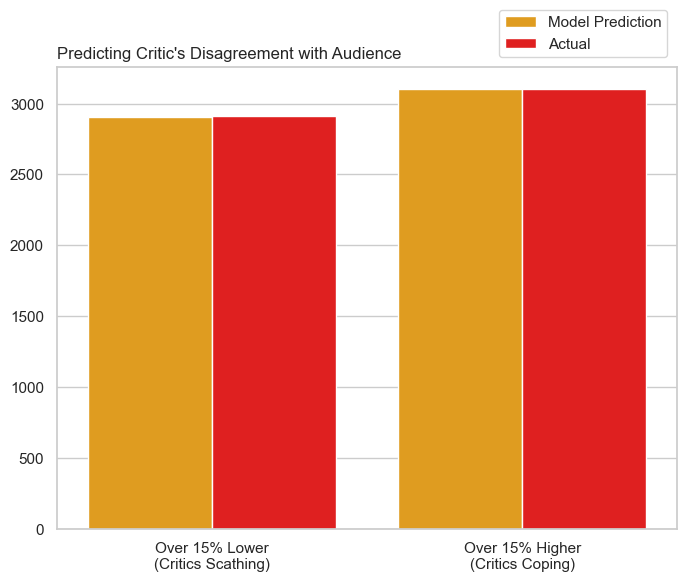

In [177]:
y_df = pd.DataFrame({'Category': np.concatenate((y_pred, y_test_np)),
                   'Source': ['Model Prediction'] * len(y_pred) + ['Actual'] * len(y_test_np)})
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=y_df, x='Category', hue='Source', palette={'Model Prediction': 'orange', 'Actual': 'red'})

plt.title("Predicting Critic's Disagreement with Audience", loc='left')
custom_labels = ['Over 15% Lower\n(Critics Scathing)', 'Over 15% Higher\n(Critics Coping)']
plt.xticks(np.arange(len(custom_labels)), custom_labels, rotation=0)
plt.legend(bbox_to_anchor=(0.7, 1.14), loc='upper left')
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('BERT_Binary_categorical_pred_vs_test.png')
plt.show()

In [131]:
# Saving model
with open('BERT_categorical_outliers_model.pkl', 'wb') as file:
    pickle.dump(model, file)

## Random Forest Classifier

In [138]:
%%notify
f_cores = cores-10
fmodel = RandomForestClassifier(n_estimators=50, n_jobs=f_cores, random_state=30)
fmodel.fit(X_train_p, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=10, random_state=30)

<IPython.core.display.Javascript object>

In [139]:
fmodel.score(X_train_p, y_train)

1.0

In [140]:
fmodel.score(X_test_p, y_test)

0.6837282074206527

## SVM Classifier (SVC)

In [ ]:
""""%%notify
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    #'epsilon': [0.1, 0.2, 0.5], # For regression models
    'gamma': ['scale', 'auto']  # For RBF kernel
}
svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train_p, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_p)""""

In [ ]:
best_model.score(X_train_p, y_train)

In [ ]:
best_model.score(X_test_p, y_test)

In [252]:
massive_merge.tail(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category,embeddings
223778,The Lord of the Rings: The Rings of Power,83.0,Gissane Sophia,Marvelous Geeks Media,Its not always easy to rewatch episodes of a l...,POSITIVE,50.0,1,"[-0.2087597, 0.32715458, 0.22976458, -0.184427..."


## Rerunning with only Text

In [193]:
'''Splitting train and test from UNCODED massive_merge dataframe by bottom rows'''
# Gathering total rows of combined
total_rows = len(massive_merge)
# Number of rows to keep for training (all except the last n, which are from Athen & Jim picks)
train_rows = total_rows - 56 #'''Remember 56 for this sample and this dataset'''
# Splitting Train from massive df and Test from massive_outliers
massive_main = massive_merge.iloc[:train_rows, :]
massive_val = massive_merge.iloc[train_rows:, :]

In [198]:
# Splitting X and y
X = massive_main['reviewText']
y = massive_main['delta_category']
# Splitting X and y
X_val = massive_val['reviewText']
y_val = massive_val['delta_category']
# Converting Category datatype to integer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Vectorized-Text-Only Log Regression

In [211]:
%%notify
# Text preprocessing function
def preprocess(text):
    # Replace &#8217; and &#44; with an empty string
    cleaned_text = text.replace("&#8217;", "")
    cleaned_text = cleaned_text.replace("&#44;", "")
    # Split the cleaned text into tokens
    tokens = cleaned_text.split(" ")
    # Remove empty tokens
    tokens = [t for t in tokens if t]
    # Join the cleaned tokens back together
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Function to vectorize text with BERT
def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean
# Applying the function to reviewText and outputting to embeddings column
massive_merge['embeddings'] = massive_merge.reviewText.map(lambda x: get_embedding(x))

<IPython.core.display.Javascript object>

In [253]:
Tvectors = np.array(massive_merge.embeddings.tolist(), dtype='float')
Tv_df = pd.DataFrame(Tvectors, columns=[f'col{i+1}' for i in range(Tvectors.shape[1])])
ttotal_rows = len(massive_merge)
ttrain_rows = ttotal_rows - 29 # 56 including Jigsaw, 29 without
T_X_main = Tv_df.iloc[:ttrain_rows, :]
T_X_val = Tv_df.iloc[ttrain_rows:, :]
T_y = massive_main['delta_category']
T_y_val = massive_val['delta_category']
TX_train, TX_test, Ty_train, Ty_test = train_test_split(T_X_main, T_y, test_size=0.25, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [223750, 24052]

In [ ]:
%%notify
# Training learning model
model = LogisticRegression(max_iter=5000)
model.fit(TX_train, Ty_train)

In [231]:
print(model.score(TX_train, Ty_train))
print(model.score(TX_test, Ty_test))
model.predict(TX_test)

0.6877321359277122
0.6407783136537502


array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [225]:
print(TX_train.shape)
print(TX_test.shape)
print(T_X_val.shape)
print(Ty_train.shape)
print(Ty_test.shape)
print(T_y_val.shape)

(18039, 768)
(6013, 768)
(56, 768)
(18039,)
(6013,)
(56,)


In [226]:
massive_main.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
0,Mahogany,30.0,Rich Cline,Shadows on the Wall,supremely corny but rather enjoyable too,POSITIVE,-46.0,0


## SHAP Model Explainer

In [233]:
from sklearn.utils import shuffle
from io import StringIO
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [ ]:
shap.plots.bar(shap_values[:, "problematic"])

In [ ]:
# Visualize SHAP values as text
shap.plots.text(shap_values[:3])